# Code generation with RAG and self-correction

AlphaCodium presented an approach for code generation that uses control flow.

Main idea: [construct an answer to a coding question iteratively.](https://x.com/karpathy/status/1748043513156272416?s=20). 

[AlphaCodium](https://github.com/Codium-ai/AlphaCodium) iteravely tests and improves an answer on public and AI-generated tests for a particular question. 

We will implement some of these ideas from scratch using [LangGraph](https://langchain-ai.github.io/langgraph/):

1. We start with a set of documentation specified by a user
2. We use a long context LLM to ingest it and perform RAG to answer a question based upon it
3. We will invoke a tool to produce a structured output
4. We will perform two unit tests (check imports and code execution) prior returning the solution to the user 

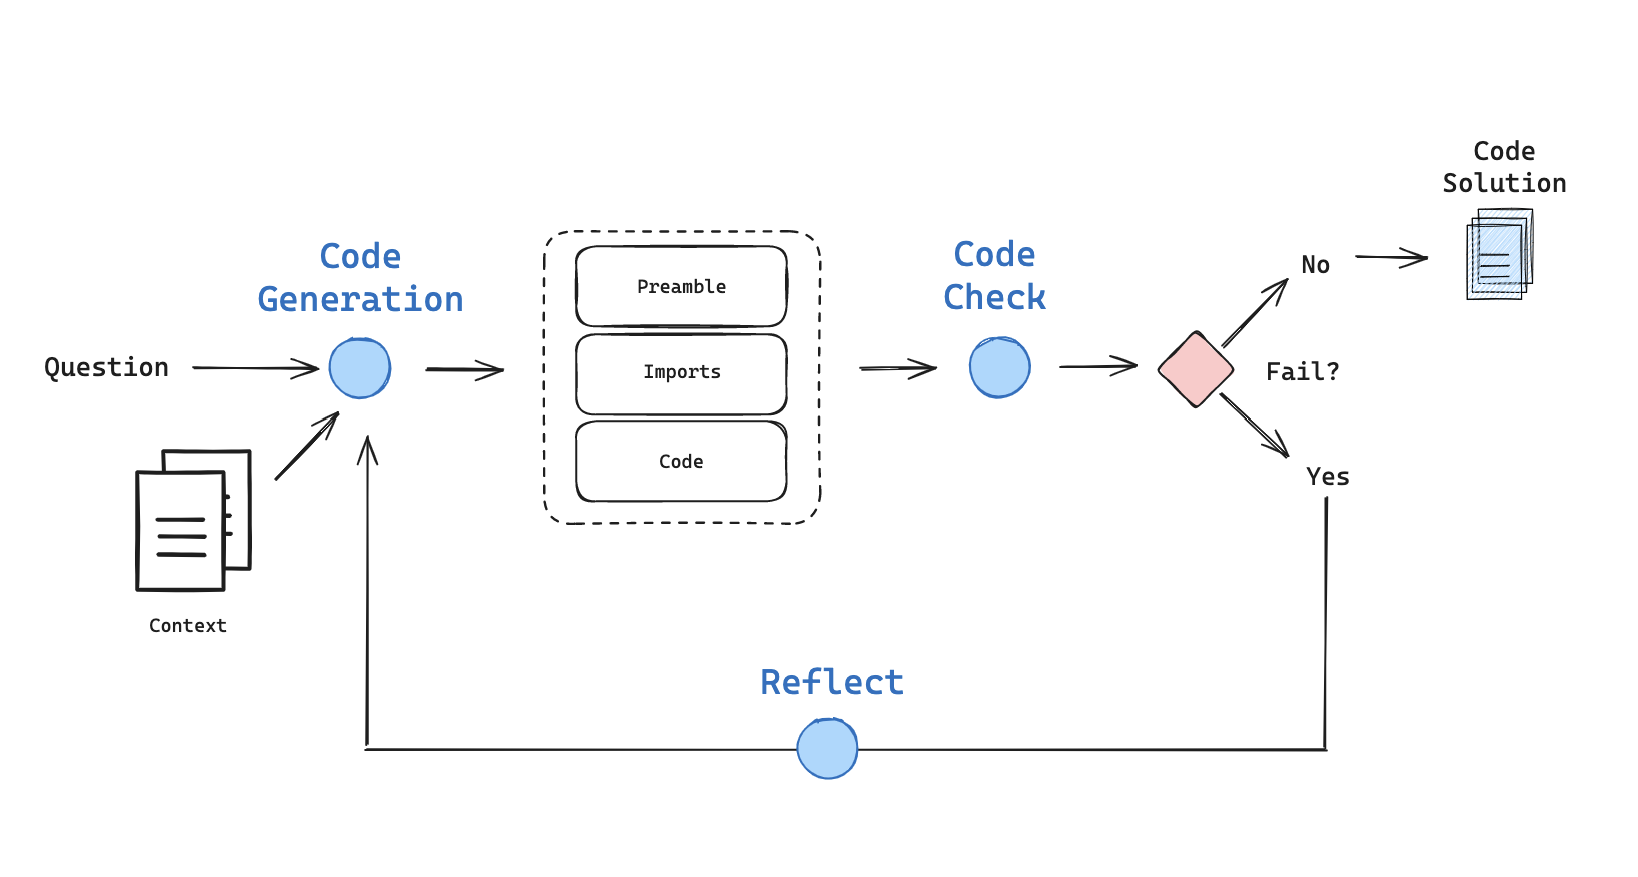

## Setup

First, let's install our required packages and set the API keys we will need

In [ ]:
! pip install -U langchain_community langchain-openai langchain-anthropic langchain langgraph bs4

In [ ]:
import getpass
import os


def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")


_set_env("OPENAI_API_KEY")
_set_env("ANTHROPIC_API_KEY")

<div class="admonition tip">
    <p class="admonition-title">Set up <a href="https://smith.langchain.com">LangSmith</a> for LangGraph development</p>
    <p style="padding-top: 5px;">
        Sign up for LangSmith to quickly spot issues and improve the performance of your LangGraph projects. LangSmith lets you use trace data to debug, test, and monitor your LLM apps built with LangGraph — read more about how to get started <a href="https://docs.smith.langchain.com">here</a>. 
    </p>
</div>

## Docs

Load [LangChain Expression Language](https://python.langchain.com/docs/concepts/#langchain-expression-language-lcel) (LCEL) docs as an example.

In [1]:
from bs4 import BeautifulSoup as Soup
from langchain_community.document_loaders.recursive_url_loader import RecursiveUrlLoader

# LCEL docs
url = "https://python.langchain.com/docs/concepts/lcel/"
loader = RecursiveUrlLoader(
    url=url, max_depth=20, extractor=lambda x: Soup(x, "html.parser").text
)
docs = loader.load()

# Sort the list based on the URLs and get the text
d_sorted = sorted(docs, key=lambda x: x.metadata["source"])
d_reversed = list(reversed(d_sorted))
concatenated_content = "\n\n\n --- \n\n\n".join(
    [doc.page_content for doc in d_reversed]
)

## LLMs

### Code solution

First, we will try OpenAI and [Claude3](https://python.langchain.com/docs/integrations/providers/anthropic/) with function calling.

We will create a `code_gen_chain` w/ either OpenAI or Claude and test them here.

<div class="admonition note">
    <p class="admonition-title">Using Pydantic with LangChain</p>
    <p>
        This notebook uses Pydantic v2 <code>BaseModel</code>, which requires <code>langchain-core >= 0.3</code>. Using <code>langchain-core < 0.3</code> will result in errors due to mixing of Pydantic v1 and v2 <code>BaseModels</code>.
    </p>
</div>

In [5]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI
from pydantic import BaseModel, Field

### OpenAI

# Grader prompt
code_gen_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            """You are a coding assistant with expertise in LCEL, LangChain expression language. \n 
    Here is a full set of LCEL documentation:  \n ------- \n  {context} \n ------- \n Answer the user 
    question based on the above provided documentation. Ensure any code you provide can be executed \n 
    with all required imports and variables defined. Structure your answer with a description of the code solution. \n
    Then list the imports. And finally list the functioning code block. Here is the user question:""",
        ),
        ("placeholder", "{messages}"),
    ]
)


# Data model
class code(BaseModel):
    """Schema for code solutions to questions about LCEL."""

    prefix: str = Field(description="Description of the problem and approach")
    imports: str = Field(description="Code block import statements")
    code: str = Field(description="Code block not including import statements")


expt_llm = "gpt-4o-mini"
llm = ChatOpenAI(temperature=0, model=expt_llm)
code_gen_chain_oai = code_gen_prompt | llm.with_structured_output(code)
question = "How do I build a RAG chain in LCEL?"
solution = code_gen_chain_oai.invoke(
    {"context": concatenated_content, "messages": [("user", question)]}
)
solution

code(prefix='To build a Retrieval-Augmented Generation (RAG) chain in LCEL, you will need to set up a chain that combines a retriever and a language model (LLM). The retriever will fetch relevant documents based on a query, and the LLM will generate a response using the retrieved documents as context. Here’s how you can do it:', imports='from langchain_core.prompts import ChatPromptTemplate\nfrom langchain_openai import ChatOpenAI\nfrom langchain_core.output_parsers import StrOutputParser\nfrom langchain_core.retrievers import MyRetriever', code='# Define the retriever\nretriever = MyRetriever()  # Replace with your specific retriever implementation\n\n# Define the LLM model\nmodel = ChatOpenAI(model="gpt-4")\n\n# Create a prompt template for the LLM\nprompt_template = ChatPromptTemplate.from_template("Given the following documents, answer the question: {question}\nDocuments: {documents}")\n\n# Create the RAG chain\nrag_chain = prompt_template | retriever | model | StrOutputParser()\n\

In [6]:
from langchain_anthropic import ChatAnthropic
from langchain_core.prompts import ChatPromptTemplate

### Anthropic

# Prompt to enforce tool use
code_gen_prompt_claude = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            """<instructions> You are a coding assistant with expertise in LCEL, LangChain expression language. \n 
    Here is the LCEL documentation:  \n ------- \n  {context} \n ------- \n Answer the user  question based on the \n 
    above provided documentation. Ensure any code you provide can be executed with all required imports and variables \n
    defined. Structure your answer: 1) a prefix describing the code solution, 2) the imports, 3) the functioning code block. \n
    Invoke the code tool to structure the output correctly. </instructions> \n Here is the user question:""",
        ),
        ("placeholder", "{messages}"),
    ]
)


# LLM
expt_llm = "claude-3-opus-20240229"
llm = ChatAnthropic(
    model=expt_llm,
    default_headers={"anthropic-beta": "tools-2024-04-04"},
)

structured_llm_claude = llm.with_structured_output(code, include_raw=True)


# Optional: Check for errors in case tool use is flaky
def check_claude_output(tool_output):
    """Check for parse error or failure to call the tool"""

    # Error with parsing
    if tool_output["parsing_error"]:
        # Report back output and parsing errors
        print("Parsing error!")
        raw_output = str(tool_output["raw"].content)
        error = tool_output["parsing_error"]
        raise ValueError(
            f"Error parsing your output! Be sure to invoke the tool. Output: {raw_output}. \n Parse error: {error}"
        )

    # Tool was not invoked
    elif not tool_output["parsed"]:
        print("Failed to invoke tool!")
        raise ValueError(
            "You did not use the provided tool! Be sure to invoke the tool to structure the output."
        )
    return tool_output


# Chain with output check
code_chain_claude_raw = (
    code_gen_prompt_claude | structured_llm_claude | check_claude_output
)


def insert_errors(inputs):
    """Insert errors for tool parsing in the messages"""

    # Get errors
    error = inputs["error"]
    messages = inputs["messages"]
    messages += [
        (
            "assistant",
            f"Retry. You are required to fix the parsing errors: {error} \n\n You must invoke the provided tool.",
        )
    ]
    return {
        "messages": messages,
        "context": inputs["context"],
    }


# This will be run as a fallback chain
fallback_chain = insert_errors | code_chain_claude_raw
N = 3  # Max re-tries
code_gen_chain_re_try = code_chain_claude_raw.with_fallbacks(
    fallbacks=[fallback_chain] * N, exception_key="error"
)


def parse_output(solution):
    """When we add 'include_raw=True' to structured output,
    it will return a dict w 'raw', 'parsed', 'parsing_error'."""

    return solution["parsed"]


# Optional: With re-try to correct for failure to invoke tool
code_gen_chain = code_gen_chain_re_try | parse_output

# No re-try
code_gen_chain = code_gen_prompt_claude | structured_llm_claude | parse_output

In [7]:
# Test
question = "How do I build a RAG chain in LCEL?"
solution = code_gen_chain.invoke(
    {"context": concatenated_content, "messages": [("user", question)]}
)
solution

code(prefix="To build a RAG (Retrieval Augmented Generation) chain in LCEL, you can use a retriever to fetch relevant documents and then pass those documents to a chat model to generate a response based on the retrieved context. Here's an example of how to do this:", imports='from langchain_expressions import retrieve, chat_completion', code='question = "What is the capital of France?"\n\nrelevant_docs = retrieve(question)\n\nresult = chat_completion(\n    model=\'openai-gpt35\', \n    messages=[\n        {{{"role": "system", "content": "Answer the question based on the retrieved context.}}},\n        {{{"role": "user", "content": \'\'\'\n            Context: {relevant_docs}\n            Question: {question}\n        \'\'\'}}\n    ]\n)\n\nprint(result)')

## State 

Our state is a dict that will contain keys (errors, question, code generation) relevant to code generation.

In [8]:
from typing import List
from typing_extensions import TypedDict


class GraphState(TypedDict):
    """
    Represents the state of our graph.

    Attributes:
        error : Binary flag for control flow to indicate whether test error was tripped
        messages : With user question, error messages, reasoning
        generation : Code solution
        iterations : Number of tries
    """

    error: str
    messages: List
    generation: str
    iterations: int

## Graph 

Our graph lays out the logical flow shown in the figure above.

In [9]:
### Parameter

# Max tries
max_iterations = 3
# Reflect
# flag = 'reflect'
flag = "do not reflect"

### Nodes


def generate(state: GraphState):
    """
    Generate a code solution

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, generation
    """

    print("---GENERATING CODE SOLUTION---")

    # State
    messages = state["messages"]
    iterations = state["iterations"]
    error = state["error"]

    # We have been routed back to generation with an error
    if error == "yes":
        messages += [
            (
                "user",
                "Now, try again. Invoke the code tool to structure the output with a prefix, imports, and code block:",
            )
        ]

    # Solution
    code_solution = code_gen_chain.invoke(
        {"context": concatenated_content, "messages": messages}
    )
    messages += [
        (
            "assistant",
            f"{code_solution.prefix} \n Imports: {code_solution.imports} \n Code: {code_solution.code}",
        )
    ]

    # Increment
    iterations = iterations + 1
    return {"generation": code_solution, "messages": messages, "iterations": iterations}


def code_check(state: GraphState):
    """
    Check code

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, error
    """

    print("---CHECKING CODE---")

    # State
    messages = state["messages"]
    code_solution = state["generation"]
    iterations = state["iterations"]

    # Get solution components
    imports = code_solution.imports
    code = code_solution.code

    # Check imports
    try:
        exec(imports)
    except Exception as e:
        print("---CODE IMPORT CHECK: FAILED---")
        error_message = [("user", f"Your solution failed the import test: {e}")]
        messages += error_message
        return {
            "generation": code_solution,
            "messages": messages,
            "iterations": iterations,
            "error": "yes",
        }

    # Check execution
    try:
        exec(imports + "\n" + code)
    except Exception as e:
        print("---CODE BLOCK CHECK: FAILED---")
        error_message = [("user", f"Your solution failed the code execution test: {e}")]
        messages += error_message
        return {
            "generation": code_solution,
            "messages": messages,
            "iterations": iterations,
            "error": "yes",
        }

    # No errors
    print("---NO CODE TEST FAILURES---")
    return {
        "generation": code_solution,
        "messages": messages,
        "iterations": iterations,
        "error": "no",
    }


def reflect(state: GraphState):
    """
    Reflect on errors

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, generation
    """

    print("---GENERATING CODE SOLUTION---")

    # State
    messages = state["messages"]
    iterations = state["iterations"]
    code_solution = state["generation"]

    # Prompt reflection

    # Add reflection
    reflections = code_gen_chain.invoke(
        {"context": concatenated_content, "messages": messages}
    )
    messages += [("assistant", f"Here are reflections on the error: {reflections}")]
    return {"generation": code_solution, "messages": messages, "iterations": iterations}


### Edges


def decide_to_finish(state: GraphState):
    """
    Determines whether to finish.

    Args:
        state (dict): The current graph state

    Returns:
        str: Next node to call
    """
    error = state["error"]
    iterations = state["iterations"]

    if error == "no" or iterations == max_iterations:
        print("---DECISION: FINISH---")
        return "end"
    else:
        print("---DECISION: RE-TRY SOLUTION---")
        if flag == "reflect":
            return "reflect"
        else:
            return "generate"

In [10]:
from langgraph.graph import END, StateGraph, START

workflow = StateGraph(GraphState)

# Define the nodes
workflow.add_node("generate", generate)  # generation solution
workflow.add_node("check_code", code_check)  # check code
workflow.add_node("reflect", reflect)  # reflect

# Build graph
workflow.add_edge(START, "generate")
workflow.add_edge("generate", "check_code")
workflow.add_conditional_edges(
    "check_code",
    decide_to_finish,
    {
        "end": END,
        "reflect": "reflect",
        "generate": "generate",
    },
)
workflow.add_edge("reflect", "generate")
app = workflow.compile()

In [13]:
question = "How can I directly pass a string to a runnable and use it to construct the input needed for my prompt?"
solution = app.invoke({"messages": [("user", question)], "iterations": 0, "error": ""})

---GENERATING CODE SOLUTION---
---CHECKING CODE---
---CODE IMPORT CHECK: FAILED---
---DECISION: RE-TRY SOLUTION---
---GENERATING CODE SOLUTION---
---CHECKING CODE---
---CODE IMPORT CHECK: FAILED---
---DECISION: RE-TRY SOLUTION---
---GENERATING CODE SOLUTION---
---CHECKING CODE---
---CODE BLOCK CHECK: FAILED---
---DECISION: FINISH---


In [18]:
solution["generation"]

code(prefix='To directly pass a string to a runnable and use it to construct the input needed for a prompt, you can use the `_from_value` method on a PromptTemplate in LCEL. Create a PromptTemplate with the desired template string, then call `_from_value` on it with a dictionary mapping the input variable names to their values. This will return a PromptValue that you can pass directly to any chain or model that accepts a prompt input.', imports='from langchain_core.prompts import PromptTemplate', code='user_string = "langchain is awesome"\n\nprompt_template = PromptTemplate.from_template("Tell me more about how {user_input}.")\n\nprompt_value = prompt_template._from_value({"user_input": user_string})\n\n# Pass the PromptValue directly to a model or chain \nchain.run(prompt_value)')

## Eval

[Here](https://smith.langchain.com/public/326674a6-62bd-462d-88ae-eea49d503f9d/d) is a public dataset of LCEL questions. 

I saved this as `lcel-teacher-eval`.

You can also find the csv [here](https://github.com/langchain-ai/lcel-teacher/blob/main/eval/eval.csv).

In [19]:
import langsmith

client = langsmith.Client()

In [20]:
# Clone the dataset to your tenant to use it
try:
    public_dataset = (
        "https://smith.langchain.com/public/326674a6-62bd-462d-88ae-eea49d503f9d/d"
    )
    client.clone_public_dataset(public_dataset)
except:
    print("Please setup LangSmith")

Dataset(name='lcel-teacher-eval', description='Eval set for LCEL teacher', data_type=<DataType.kv: 'kv'>, id=UUID('8b57696d-14ea-4f00-9997-b3fc74a16846'), created_at=datetime.datetime(2024, 9, 16, 22, 50, 4, 169288, tzinfo=datetime.timezone.utc), modified_at=datetime.datetime(2024, 9, 16, 22, 50, 4, 169288, tzinfo=datetime.timezone.utc), example_count=0, session_count=0, last_session_start_time=None, inputs_schema=None, outputs_schema=None)

Custom evals.

In [21]:
from langsmith.schemas import Example, Run


def check_import(run: Run, example: Example) -> dict:
    imports = run.outputs.get("imports")
    try:
        exec(imports)
        return {"key": "import_check", "score": 1}
    except Exception:
        return {"key": "import_check", "score": 0}


def check_execution(run: Run, example: Example) -> dict:
    imports = run.outputs.get("imports")
    code = run.outputs.get("code")
    try:
        exec(imports + "\n" + code)
        return {"key": "code_execution_check", "score": 1}
    except Exception:
        return {"key": "code_execution_check", "score": 0}

Compare LangGraph to Context Stuffing.

In [33]:
def predict_base_case(example: dict):
    """Context stuffing"""
    solution = code_gen_chain.invoke(
        {"context": concatenated_content, "messages": [("user", example["question"])]}
    )
    return {"imports": solution.imports, "code": solution.code}


def predict_langgraph(example: dict):
    """LangGraph"""
    graph = app.invoke(
        {"messages": [("user", example["question"])], "iterations": 0, "error": ""}
    )
    solution = graph["generation"]
    return {"imports": solution.imports, "code": solution.code}

In [34]:
from langsmith.evaluation import evaluate

# Evaluator
code_evalulator = [check_import, check_execution]

# Dataset
dataset_name = "lcel-teacher-eval"

In [ ]:
# Run base case
try:
    experiment_results_ = evaluate(
        predict_base_case,
        data=dataset_name,
        evaluators=code_evalulator,
        experiment_prefix=f"test-without-langgraph-{expt_llm}",
        max_concurrency=2,
        metadata={
            "llm": expt_llm,
        },
    )
except:
    print("Please setup LangSmith")

In [ ]:
# Run with langgraph
try:
    experiment_results = evaluate(
        predict_langgraph,
        data=dataset_name,
        evaluators=code_evalulator,
        experiment_prefix=f"test-with-langgraph-{expt_llm}-{flag}",
        max_concurrency=2,
        metadata={
            "llm": expt_llm,
            "feedback": flag,
        },
    )
except:
    print("Please setup LangSmith")

`Results:`

* `LangGraph outperforms base case`: adding re-try loop improve performance
* `Reflection did not help`: reflection prior to re-try regression vs just passing errors directly back to the LLM
* `GPT-4 outperforms Claude3`: Claude3 had 3 and 1 run fail due to tool-use error for Opus and Haiku, respectively

https://smith.langchain.com/public/78a3d858-c811-4e46-91cb-0f10ef56260b/d